## Define the Convolutional Neural Network

After we've looked at the data we're working with and, in this case, know the shapes of the images and of the keypoints,we are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, we will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

A CNN is defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers
 
> We will define the neural network in the models.py file

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2019-10-17 21:17:29--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.136.206
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.136.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.1’

train-test-data.zip 100%[===================>] 322.93M  63.6MB/s    in 4.9s    

2019-10-17 21:17:34 (65.5 MB/s) - ‘/data/train-test-data.zip.1’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2)
  (fc1): Linear(in_features=36864, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [9]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [10]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [11]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [12]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [13]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [14]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [15]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [16]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

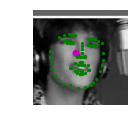

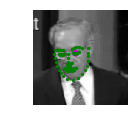

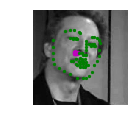

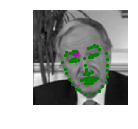

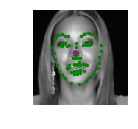

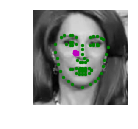

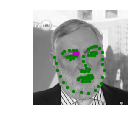

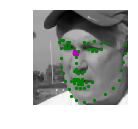

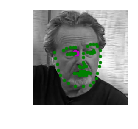

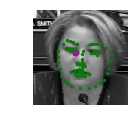

In [17]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [37]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion =  nn.MSELoss()

learning_rate = 0.001

optimizer = optim.Adam(net.parameters(), lr = learning_rate, betas=(0.9, 0.999),eps=1e-08) # like the default for eps and betas 


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [32]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [38]:
# train your network
n_epochs = 10 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.722349438071251
Epoch: 1, Batch: 20, Avg. Loss: 0.42105464935302733
Epoch: 1, Batch: 30, Avg. Loss: 0.2527083694934845
Epoch: 1, Batch: 40, Avg. Loss: 0.18497170954942704
Epoch: 1, Batch: 50, Avg. Loss: 0.19376538395881654
Epoch: 1, Batch: 60, Avg. Loss: 0.2399548277258873
Epoch: 1, Batch: 70, Avg. Loss: 0.16615458577871323
Epoch: 1, Batch: 80, Avg. Loss: 0.22288194745779039
Epoch: 1, Batch: 90, Avg. Loss: 0.1841080218553543
Epoch: 1, Batch: 100, Avg. Loss: 0.21410688161849975
Epoch: 1, Batch: 110, Avg. Loss: 0.17591406553983688
Epoch: 1, Batch: 120, Avg. Loss: 0.1694933295249939
Epoch: 1, Batch: 130, Avg. Loss: 0.17802607119083405
Epoch: 1, Batch: 140, Avg. Loss: 0.18960267603397368
Epoch: 1, Batch: 150, Avg. Loss: 0.2143065020442009
Epoch: 1, Batch: 160, Avg. Loss: 0.21515247747302055
Epoch: 1, Batch: 170, Avg. Loss: 0.21043997034430503
Epoch: 1, Batch: 180, Avg. Loss: 0.14903334602713586
Epoch: 1, Batch: 190, Avg. Loss: 0.196672722697258
Epoch: 1, B

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.17305456548929216
Epoch: 2, Batch: 20, Avg. Loss: 0.19954577311873437
Epoch: 2, Batch: 30, Avg. Loss: 0.16908112168312073
Epoch: 2, Batch: 40, Avg. Loss: 0.14882342666387557
Epoch: 2, Batch: 50, Avg. Loss: 0.19642167314887046
Epoch: 2, Batch: 60, Avg. Loss: 0.17128600403666497
Epoch: 2, Batch: 70, Avg. Loss: 0.16315316259860993
Epoch: 2, Batch: 80, Avg. Loss: 0.16100512444972992
Epoch: 2, Batch: 90, Avg. Loss: 0.1352864496409893
Epoch: 2, Batch: 100, Avg. Loss: 0.15289892256259918
Epoch: 2, Batch: 110, Avg. Loss: 0.1820245198905468
Epoch: 2, Batch: 120, Avg. Loss: 0.1872312467545271
Epoch: 2, Batch: 130, Avg. Loss: 0.14947409480810164
Epoch: 2, Batch: 140, Avg. Loss: 0.1399124011397362
Epoch: 2, Batch: 150, Avg. Loss: 0.1685259610414505
Epoch: 2, Batch: 160, Avg. Loss: 0.1656242311000824
Epoch: 2, Batch: 170, Avg. Loss: 0.15521440282464027
Epoch: 2, Batch: 180, Avg. Loss: 0.13159008249640464
Epoch: 2, Batch: 190, Avg. Loss: 0.14607230052351952
Epoch: 2

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.1646298162639141
Epoch: 3, Batch: 20, Avg. Loss: 0.1569875068962574
Epoch: 3, Batch: 30, Avg. Loss: 0.09674642831087113
Epoch: 3, Batch: 40, Avg. Loss: 0.10484830550849437
Epoch: 3, Batch: 50, Avg. Loss: 0.10499301925301552
Epoch: 3, Batch: 60, Avg. Loss: 0.09075649045407772
Epoch: 3, Batch: 70, Avg. Loss: 0.10687869153916836
Epoch: 3, Batch: 80, Avg. Loss: 0.16093437597155572
Epoch: 3, Batch: 90, Avg. Loss: 0.21271522715687752
Epoch: 3, Batch: 100, Avg. Loss: 0.10672767385840416
Epoch: 3, Batch: 110, Avg. Loss: 0.1313219167292118
Epoch: 3, Batch: 120, Avg. Loss: 0.09332575276494026
Epoch: 3, Batch: 130, Avg. Loss: 0.09453906193375587
Epoch: 3, Batch: 140, Avg. Loss: 0.09093967005610466
Epoch: 3, Batch: 150, Avg. Loss: 0.12458905950188637
Epoch: 3, Batch: 160, Avg. Loss: 0.08734620474278927
Epoch: 3, Batch: 170, Avg. Loss: 0.10496778339147568
Epoch: 3, Batch: 180, Avg. Loss: 0.10077353417873383
Epoch: 3, Batch: 190, Avg. Loss: 0.10151157528162003
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.10789419338107109
Epoch: 4, Batch: 20, Avg. Loss: 0.10179853960871696
Epoch: 4, Batch: 30, Avg. Loss: 0.10459907464683056
Epoch: 4, Batch: 40, Avg. Loss: 0.08423711583018303
Epoch: 4, Batch: 50, Avg. Loss: 0.10472542941570281
Epoch: 4, Batch: 60, Avg. Loss: 0.08911739960312844
Epoch: 4, Batch: 70, Avg. Loss: 0.08592995442450047
Epoch: 4, Batch: 80, Avg. Loss: 0.07953491657972336
Epoch: 4, Batch: 90, Avg. Loss: 0.06752390153706074
Epoch: 4, Batch: 100, Avg. Loss: 0.0988461147993803
Epoch: 4, Batch: 110, Avg. Loss: 0.06386112235486507
Epoch: 4, Batch: 120, Avg. Loss: 0.07484491243958473
Epoch: 4, Batch: 130, Avg. Loss: 0.09882630705833435
Epoch: 4, Batch: 140, Avg. Loss: 0.08595048412680625
Epoch: 4, Batch: 150, Avg. Loss: 0.10490791909396649
Epoch: 4, Batch: 160, Avg. Loss: 0.12664956972002983
Epoch: 4, Batch: 170, Avg. Loss: 0.10266458280384541
Epoch: 4, Batch: 180, Avg. Loss: 0.08132692500948906
Epoch: 4, Batch: 190, Avg. Loss: 0.07684852294623852
Epo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.11007228903472424
Epoch: 5, Batch: 20, Avg. Loss: 0.07378308884799481
Epoch: 5, Batch: 30, Avg. Loss: 0.10223676934838295
Epoch: 5, Batch: 40, Avg. Loss: 0.09208371825516223
Epoch: 5, Batch: 50, Avg. Loss: 0.07101596668362617
Epoch: 5, Batch: 60, Avg. Loss: 0.08506127037107944
Epoch: 5, Batch: 70, Avg. Loss: 0.08225606754422188
Epoch: 5, Batch: 80, Avg. Loss: 0.11289924457669258
Epoch: 5, Batch: 90, Avg. Loss: 0.07927593849599361
Epoch: 5, Batch: 100, Avg. Loss: 0.06794129312038422
Epoch: 5, Batch: 110, Avg. Loss: 0.08156643435359001
Epoch: 5, Batch: 120, Avg. Loss: 0.10168878305703402
Epoch: 5, Batch: 130, Avg. Loss: 0.1255857814103365
Epoch: 5, Batch: 140, Avg. Loss: 0.08859643042087555
Epoch: 5, Batch: 150, Avg. Loss: 0.0729268230497837
Epoch: 5, Batch: 160, Avg. Loss: 0.08761840090155601
Epoch: 5, Batch: 170, Avg. Loss: 0.06326180696487427
Epoch: 5, Batch: 180, Avg. Loss: 0.059333831816911695
Epoch: 5, Batch: 190, Avg. Loss: 0.06925153732299805
Epo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.1439525406807661
Epoch: 6, Batch: 20, Avg. Loss: 0.08130750693380832
Epoch: 6, Batch: 30, Avg. Loss: 0.09210363999009133
Epoch: 6, Batch: 40, Avg. Loss: 0.07559105269610882
Epoch: 6, Batch: 50, Avg. Loss: 0.08490577079355717
Epoch: 6, Batch: 60, Avg. Loss: 0.07502341903746128
Epoch: 6, Batch: 70, Avg. Loss: 0.08779954053461551
Epoch: 6, Batch: 80, Avg. Loss: 0.0652743499726057
Epoch: 6, Batch: 90, Avg. Loss: 0.058731944486498835
Epoch: 6, Batch: 100, Avg. Loss: 0.06856610104441643
Epoch: 6, Batch: 110, Avg. Loss: 0.20762644410133363
Epoch: 6, Batch: 120, Avg. Loss: 0.09990367125719786
Epoch: 6, Batch: 130, Avg. Loss: 0.0815526731312275
Epoch: 6, Batch: 140, Avg. Loss: 0.09526093378663063
Epoch: 6, Batch: 150, Avg. Loss: 0.07476589940488339
Epoch: 6, Batch: 160, Avg. Loss: 0.10393291637301445
Epoch: 6, Batch: 170, Avg. Loss: 0.08966327533125877
Epoch: 6, Batch: 180, Avg. Loss: 0.14398691542446612
Epoch: 6, Batch: 190, Avg. Loss: 0.07573859393596649
Epoc

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.11873693577945232
Epoch: 7, Batch: 20, Avg. Loss: 0.08990388028323651
Epoch: 7, Batch: 30, Avg. Loss: 0.09105070251971484
Epoch: 7, Batch: 40, Avg. Loss: 0.06468236036598682
Epoch: 7, Batch: 50, Avg. Loss: 0.07870623916387558
Epoch: 7, Batch: 60, Avg. Loss: 0.05765621289610863
Epoch: 7, Batch: 70, Avg. Loss: 0.11395488418638706
Epoch: 7, Batch: 80, Avg. Loss: 0.05813099443912506
Epoch: 7, Batch: 90, Avg. Loss: 0.057048804871737954
Epoch: 7, Batch: 100, Avg. Loss: 0.0579100027680397
Epoch: 7, Batch: 110, Avg. Loss: 0.0703555341809988
Epoch: 7, Batch: 120, Avg. Loss: 0.07691948190331459
Epoch: 7, Batch: 130, Avg. Loss: 0.06181029267609119
Epoch: 7, Batch: 140, Avg. Loss: 0.06309501267969608
Epoch: 7, Batch: 150, Avg. Loss: 0.05487055517733097
Epoch: 7, Batch: 160, Avg. Loss: 0.09363183379173279
Epoch: 7, Batch: 170, Avg. Loss: 0.06647916734218598
Epoch: 7, Batch: 180, Avg. Loss: 0.06521694585680962
Epoch: 7, Batch: 190, Avg. Loss: 0.060232076421380044
Ep

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.06360423043370247
Epoch: 8, Batch: 20, Avg. Loss: 0.1057624951004982
Epoch: 8, Batch: 30, Avg. Loss: 0.08926290161907673
Epoch: 8, Batch: 40, Avg. Loss: 0.06567843817174435
Epoch: 8, Batch: 50, Avg. Loss: 0.08254271484911442
Epoch: 8, Batch: 60, Avg. Loss: 0.05661498680710793
Epoch: 8, Batch: 70, Avg. Loss: 0.11376220099627972
Epoch: 8, Batch: 80, Avg. Loss: 0.05872159376740456
Epoch: 8, Batch: 90, Avg. Loss: 0.07912356499582529
Epoch: 8, Batch: 100, Avg. Loss: 0.08323260117322206
Epoch: 8, Batch: 110, Avg. Loss: 0.06296059601008892
Epoch: 8, Batch: 120, Avg. Loss: 0.07706743702292443
Epoch: 8, Batch: 130, Avg. Loss: 0.07130364961922168
Epoch: 8, Batch: 140, Avg. Loss: 0.09509926997125148
Epoch: 8, Batch: 150, Avg. Loss: 0.05471756644546986
Epoch: 8, Batch: 160, Avg. Loss: 0.07592320963740348
Epoch: 8, Batch: 170, Avg. Loss: 0.05017264261841774
Epoch: 8, Batch: 180, Avg. Loss: 0.060729469358921054
Epoch: 8, Batch: 190, Avg. Loss: 0.1234879482537508
Epo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.06379959657788277
Epoch: 9, Batch: 20, Avg. Loss: 0.05730941072106362
Epoch: 9, Batch: 30, Avg. Loss: 0.048800951614975926
Epoch: 9, Batch: 40, Avg. Loss: 0.04507870562374592
Epoch: 9, Batch: 50, Avg. Loss: 0.05077031366527081
Epoch: 9, Batch: 60, Avg. Loss: 0.05958410631865263
Epoch: 9, Batch: 70, Avg. Loss: 0.04999445751309395
Epoch: 9, Batch: 80, Avg. Loss: 0.05088367313146591
Epoch: 9, Batch: 90, Avg. Loss: 0.04988308325409889
Epoch: 9, Batch: 100, Avg. Loss: 0.05906034167855978
Epoch: 9, Batch: 110, Avg. Loss: 0.08610877096652984
Epoch: 9, Batch: 120, Avg. Loss: 0.045256486535072325
Epoch: 9, Batch: 130, Avg. Loss: 0.0634158382192254
Epoch: 9, Batch: 140, Avg. Loss: 0.056568150594830516
Epoch: 9, Batch: 150, Avg. Loss: 0.052254206500947475
Epoch: 9, Batch: 160, Avg. Loss: 0.048461221158504486
Epoch: 9, Batch: 170, Avg. Loss: 0.047129308246076106
Epoch: 9, Batch: 180, Avg. Loss: 0.05389002840965986
Epoch: 9, Batch: 190, Avg. Loss: 0.061760234087705

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.08252677731215954
Epoch: 10, Batch: 20, Avg. Loss: 0.06813033595681191
Epoch: 10, Batch: 30, Avg. Loss: 0.058732441440224645
Epoch: 10, Batch: 40, Avg. Loss: 0.03961141332983971
Epoch: 10, Batch: 50, Avg. Loss: 0.07839060053229333
Epoch: 10, Batch: 60, Avg. Loss: 0.08173175603151321
Epoch: 10, Batch: 70, Avg. Loss: 0.05466576032340527
Epoch: 10, Batch: 80, Avg. Loss: 0.05561674833297729
Epoch: 10, Batch: 90, Avg. Loss: 0.06170391980558634
Epoch: 10, Batch: 100, Avg. Loss: 0.05820997469127178
Epoch: 10, Batch: 110, Avg. Loss: 0.11222858019173146
Epoch: 10, Batch: 120, Avg. Loss: 0.054000014625489715
Epoch: 10, Batch: 130, Avg. Loss: 0.06493151411414147
Epoch: 10, Batch: 140, Avg. Loss: 0.04792111311107874
Epoch: 10, Batch: 150, Avg. Loss: 0.043713180162012574
Epoch: 10, Batch: 160, Avg. Loss: 0.07813187651336193
Epoch: 10, Batch: 170, Avg. Loss: 0.06172931157052517
Epoch: 10, Batch: 180, Avg. Loss: 0.049513745307922366
Epoch: 10, Batch: 190, Avg. Loss:

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [39]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


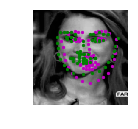

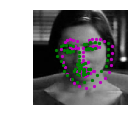

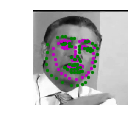

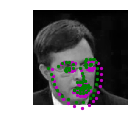

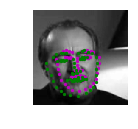

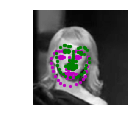

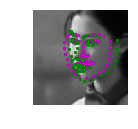

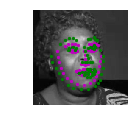

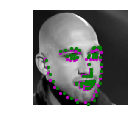

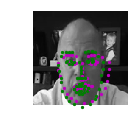

In [40]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [41]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: I have chosen the MSE ( Mean Squared Error ) as a loss function and I tried both Adadelta and Adam as optimizers . <br>
**The reasons behind these choices :** 
- For MSE the main reason was the recommendation from the [paper](https://arxiv.org/pdf/1710.00977.pdf) and it actually gave good results so I kept it.
- For the optimizers : first I used Adadelta optimizer and trained the network for about 8 epochs and I noticed that the loss kept swaying between 0.22 and 0.18 so I reduced the learning rate and trained for more epochs but the results were not improving so well So I went back to the [paper](https://arxiv.org/pdf/1710.00977.pdf) and Used Adam with betas=(0.9, 0.999),eps=1e-08 and learning rate = 0.001 and I was able to reduce the loss to 0.065.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: I tried CNN with 3 layers in the first time and then decided to increase it to 4 convolutional layers since I wanted to decrease the loss and hence to make my network spot more complex patterns and it worked. 
while searching I came acros the [SqueezeNet paper](https://arxiv.org/pdf/1602.07360.pdf) and I was amazed by the achieved results so this inspired me to use global Average pooling layer instead of the Linear layers in th end of the network and since it gave me similar results I kept the linear layers in the end of the network for this submission

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: 
- For the epochs : I observed the training so whenever my network keeps improving I kept training for more epochs, when the loss keep swaying between specific values it means I am likely to be overshooting the minima so I stop training decrease the learning rate and train again .

- For the batch size : I used a batch size of 5 then I increased it to 10.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.09180678 -0.03792909 -0.18266979 -0.19796681 -0.16636701]
 [ 0.04732481 -0.08787651 -0.1184447  -0.11079681 -0.10887664]
 [ 0.0747437   0.16514529 -0.07437389 -0.0697668  -0.12794121]
 [-0.14679423  0.08549966  0.03916034 -0.10692661 -0.03624077]
 [ 0.03115869  0.00713067 -0.15311937  0.09536506  0.03505525]]
(5, 5)


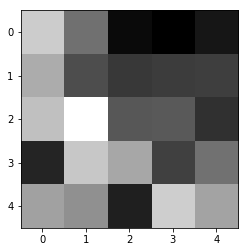

In [18]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

[[ 0.09180678 -0.03792909 -0.18266979 -0.19796681 -0.16636701]
 [ 0.04732481 -0.08787651 -0.1184447  -0.11079681 -0.10887664]
 [ 0.0747437   0.16514529 -0.07437389 -0.0697668  -0.12794121]
 [-0.14679423  0.08549966  0.03916034 -0.10692661 -0.03624077]
 [ 0.03115869  0.00713067 -0.15311937  0.09536506  0.03505525]]


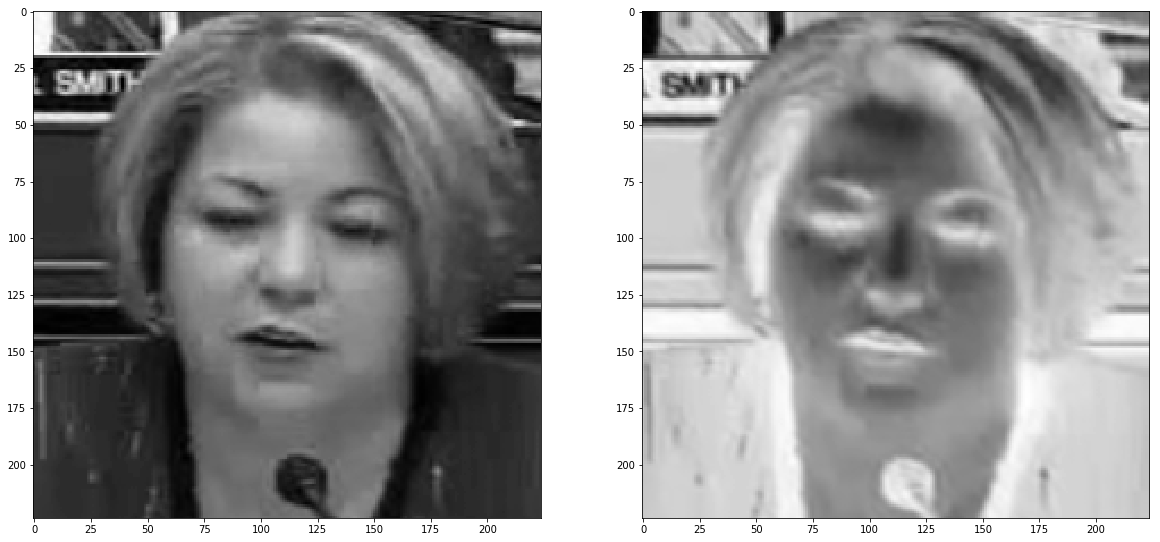

In [38]:
## apply a specific set of filter weights (like the one displayed above) to the test image
# Loading the image

import cv2

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)

image = test_images[9].data
image = image.cpu().numpy()

image = np.transpose(image, (1, 2, 0))
plt.imshow(np.squeeze(image), cmap='gray')

plt.subplot(1,2,2)
weights = net.conv1.weight.data
w = weights.cpu().numpy()
c = cv2.filter2D(image, -1, w[0][0])
plt.imshow(c, cmap='gray')


print(w[0][0])

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: We know that first Convolutional layers detect low level simple patterns this one seems like a color inverse filter.

---
## Moving on!

in the last notebook we will combine a face detector with the  saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!